<a href="https://colab.research.google.com/github/Robin-01/California-Coastal-Sea-Currents/blob/main/californiavectors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd    #dataframe to work with tables
import numpy as np     #for general calculations with arrays
!pip install pycmap
!pip install cartopy
import pycmap          #API for querrying the data from CMAP

import plotly.express as px   #makes nice interactive plots


import cartopy.crs as ccrs         # to plot maps with different projections
import cartopy.feature as cfeature # to plot coastlines, land, borders, etc.
import matplotlib.pyplot as plt  #makes regular plots

from matplotlib.colors import LogNorm  #to make logarithmic colormap axis

import xarray as xr  #to work with data

from scipy.interpolate import griddata   #interpolate irregularly spaced data onto a grid

from google.colab import drive
drive.mount('/content/drive')

CC_6km='/content/drive/MyDrive/Group Project/uswc_6km_Resolution_Hourly_RTV_best_2024_2025.nc4' #loading from local path
cc = xr.open_dataset(CC_6km)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.9/421.9 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 105.5 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
# Calculate the 12-hour mean
daily_mean_12h = cc.resample(time='12h').mean()

# Create a new time vector at 6-hour intervals
start_time = daily_mean_12h['time'].min().values
end_time = daily_mean_12h['time'].max().values
new_time_vector = pd.date_range(start=start_time, end=end_time, freq='6h')

# Task
Create a video of the 12-hour mean ocean current magnitude for approximately 30 days using the dataset "daily_mean_12h".

## Calculate 12-hour mean magnitude

### Subtask:
Compute the 12-hour mean of the ocean current magnitude using the `daily_mean_12h` dataset.


**Reasoning**:
Calculate the magnitude of the ocean current velocity and add it as a new variable to the `daily_mean_12h` dataset.



/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


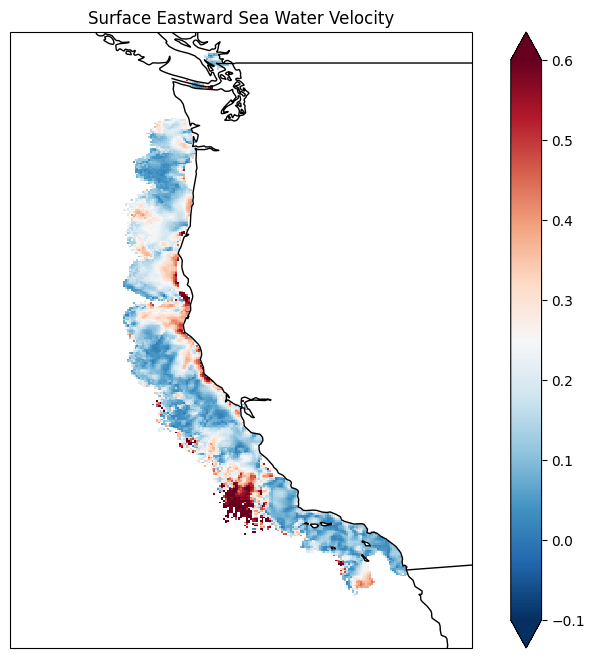

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Plot the 'v' data from the xarray dataset
u_12 = daily_mean_12h.isel(time=100)['u']
v_12 = daily_mean_12h.isel(time=100)['v']
mag_12 = np.sqrt(u_12**2 + v_12**2)
mag_12.plot(ax=ax, cmap='RdBu_r', transform=ccrs.PlateCarree(), add_colorbar=True,vmin=0.6, vmax=0)

ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)
# You might want to adjust the extent based on your data
ax.set_extent([-130, -115, 30, 50], crs=ccrs.PlateCarree())

plt.title('Surface Eastward Sea Water Velocity')
plt.savefig('u.png')
plt.show()

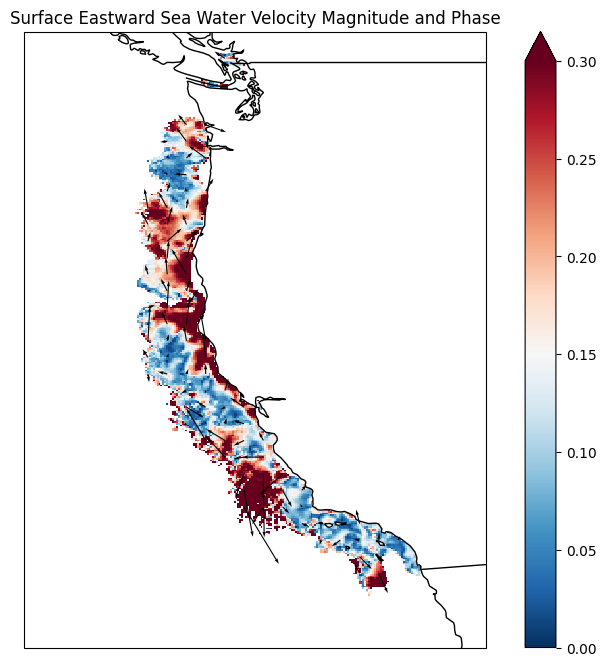

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Plot the magnitude
u_12 = daily_mean_12h.isel(time=100)['u']
v_12 = daily_mean_12h.isel(time=100)['v']
mag_12 = np.sqrt(u_12**2 + v_12**2)
mag_12.plot(ax=ax, cmap='RdBu_r', transform=ccrs.PlateCarree(), add_colorbar=True, vmin=0, vmax=0.3)

# Add quiver plot for phase (vectors)
# We need to subsample the data for the quiver plot to avoid overcrowding
skip = 10 # Adjust this value to change the density of the vectors
ax.quiver(u_12.coords['lon'][::skip], u_12.coords['lat'][::skip],
          u_12.values[::skip, ::skip], v_12.values[::skip, ::skip],
          transform=ccrs.PlateCarree(), scale=6, color='black') # Adjust scale as needed

ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)
ax.set_extent([-130, -115, 30, 50], crs=ccrs.PlateCarree())

plt.title('Surface Eastward Sea Water Velocity Magnitude and Phase')
plt.savefig('magnitude_phase.png')
plt.show()

In [ ]:
u=daily_mean_12h['u'].sel(time=slice("2024-03-01T00:00:00.000000000", "2025-01-01T00:00:00.000000000",2))
v=daily_mean_12h['v'].sel(time=slice("2024-03-01T00:00:00.000000000", "2025-01-01T00:00:00.000000000",2))
mag_video = np.sqrt(u**2 + v**2)
phase_video = np.arctan2(v, u)
from matplotlib.animation import FuncAnimation  #creating animations and videos.
from base64 import b64encode # Import b64encode

def animation_func(i):
    fig.clear()
    ax = plt.axes(projection=ccrs.PlateCarree())                  #specifying the projection such that coasline data could be added
    mag_video.isel(time=i).plot(cmap='RdBu_r',vmin=0, vmax=0.4)    #plotting the data
    ax.add_feature(cfeature.COASTLINE)                            #adding the coastline over the plotted data
    ax.add_feature(cfeature.BORDERS)
    skip = 10 # Adjust this value to change the density of the vectors
    # Fix: Use the correct u and v data for the current time step
    ax.quiver(mag_video.coords['lon'][::skip], mag_video.coords['lat'][::skip],
          u.isel(time=i).values[::skip, ::skip], v.isel(time=i).values[::skip, ::skip],
          transform=ccrs.PlateCarree(), scale=6, color='black') # Adjust scale as needed                             #adding the borders

    plt.axis('off')

fig = plt.figure(figsize=(10,8))
animation = FuncAnimation(fig, animation_func,
                          frames = len(mag_video.time))

animation.save('u.mp4')
plt.close()
from IPython.display import Video, HTML
def show_video(video_path, video_width = 800):
  video_file = open(video_path, "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")
show_video('u.mp4')